In [44]:
import numpy as np
import copy as cp
from gpcam.gp_optimizer import fvGPOptimizer
import matplotlib.pyplot as plt
from numpy.random import default_rng
import time
from typing import *
from tqdm.auto import tqdm


In [2]:

def aqf_multid(x, gp):
    a = 2.0  #####change here, 3.0 for 95 percent confidence interval
    norm = 1.0
    ret = None
    for i in range(gp.input_dim-1):
        x_pred=np.c_[x,np.zeros(x.shape[0])+i].reshape(-1,gp.input_dim)
        cov = gp.posterior_covariance(x_pred)["v(x)"]
        if ret is None:
            ret = cov
        else:
            ret += cov
            
    ret=a * np.sqrt(ret)

    for i in range(gp.input_dim-1):
        x_pred=np.c_[x,np.zeros(x.shape[0])+i].reshape(-1,gp.input_dim)
        mean = gp.posterior_mean(x_pred)["f(x)"]
        ret += norm * mean

    return ret

In [72]:
def init_gp(
        points,
        values,
        index_set_bounds,
        hyperparameter_bounds,
        hps_guess,
        vp,
        device:Literal['cpu','gpu']='cpu',
    ) -> fvGPOptimizer:
    gp = fvGPOptimizer(input_space_dimension=2, output_space_dimension=1, output_number=2, input_space_bounds=index_set_bounds, )
    gp.tell(points,values,value_positions=vp)
    gp.init_fvgp(hps_guess,compute_device=device)
    gp.train_gp(hyperparameter_bounds,pop_size = 20,tolerance = 1e-6,max_iter = 2)
    return gp


def find_next(
        points,
        values,
        gp,
        hyperparameter_bounds,
        maxnum:int=None,
        dask_client=None,
        method:Literal['global','local']='global',
    ) -> Tuple[int,int]:
    if maxnum is None:
        gp.tell(points,values)
    else:
        gp.tell(points[-maxnum:],values[-maxnum:])
    # gp.train_gp(
    #     hyperparameter_bounds=hyperparameter_bounds,
    #     pop_size = 20,
    #     method=method,
    #     tolerance = 1e-6,
    #     max_iter = 2,
    #     dask_client = dask_client,
    #     # device=device,
    # )
    #     # gp.train_gp_async(hyperparameter_bounds, max_iter = 10000, dask_client = None)

    new = gp.ask(
        position = None, 
        n = 1, 
        acquisition_function = aqf_multid, 
        bounds = None,
        method=method, 
        pop_size = 20, 
        max_iter = 20, 
        tol = 10e-6, 
        x0 = None, 
        dask_client = dask_client,
        # device=device,
    )
    x,y = np.round(new['x'][0]).astype(int)
    return x,y

def measure_next(a,new) -> np.ndarray:
    newval = a[new[0]*map_shape[1]+new[1]]
    assert np.allclose(new,newval[:2]),"coordinates don't match"
    # points.append(new)
    # values.append(a[new[0]*250+new[1]])
    return newval[2:]
    # new,a[new[0]*250+new[1]][2]



In [73]:
a = np.load(r"D:\data\us_topo.npy")
# b=cp.deepcopy(a*np.array([1,1,0]))
# b=np.append(b,(a+np.array([100,0,0]))*np.array([1,1,0]),axis=0)
# b=np.append(b,(a+np.array([200,0,0]))*np.array([1,1,0]),axis=0)
# b=np.append(b,(a+np.array([000,250,0]))*np.array([1,1,0]),axis=0)
# b=np.append(b,(a+np.array([100,250,0]))*np.array([1,1,1]),axis=0)
# b=np.append(b,(a+np.array([200,250,0]))*np.array([1,1,0]),axis=0)
# b=np.append(b,(a+np.array([000,500,0]))*np.array([1,1,0]),axis=0)
# b=np.append(b,(a+np.array([100,500,0]))*np.array([1,1,0]),axis=0)
# b=np.append(b,(a+np.array([200,500,0]))*np.array([1,1,0]),axis=0)

# b=b[np.lexsort(np.transpose(b)[::-1])]
# a=b
a = np.c_[a,3733.5*np.sin(np.flip(a[:,2])/1000)]

In [74]:
map_shape = 100,250

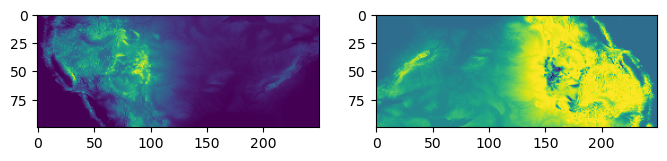

In [75]:
fig,ax=plt.subplots(1,2,figsize=(8,2))

ax[0].imshow(a[:,2].reshape(map_shape))
ax[1].imshow(a[:,3].reshape(map_shape))

# Initialize the gp

In [76]:

rng = default_rng()
ind = rng.choice(len(a)-1, size=5, replace=False)
init_points = a[ind,0:2]
init_values = a[ind,2:4]
print("x_min ", np.min(init_points[:,0])," x_max ",np.max(init_points[:,0]))
print("y_min ", np.min(init_points[:,1])," y_max ",np.max(init_points[:,1]))
print("val_min ", np.min(init_values[:,1])," val_max ",np.max(init_values[:,1]))
print("length of data set: ", len(init_values))

index_set_bounds = np.array([[0,map_shape[0]-1],[0,map_shape[1]-1]])
hyperparameter_bounds = np.array([[0.001,1e9],[1,1000],[1,1000],[1,1000],[1,1000]])
hps_guess = np.array([4.71907062e+06, 4.07439017e+02, 3.59068120e+02,4e2,4e2])

z=[[[0],[1]]]
vp = np.array(z*len(ind))



x_min  30.0  x_max  96.0
y_min  111.0  y_max  231.0
val_min  0.0  val_max  3727.9559110455316
length of data set:  5


In [77]:
n_iterations = 100

# CPU version

In [78]:
def run_gp(points,values,device,method,dask_client=None):
    """Run the GP for one iteration.
    
    Args:
        points (np.ndarray): The points that have been measured so far.
        values (np.ndarray): The values that have been measured so far.
        gp (GaussianProcess): The GP that is used to model the data.
        device (str): The device that is used for the GP.
        method (str): The method that is used for the GP.
    
    Returns:
        Tuple[np.ndarray,np.ndarray]
    """
    gp = init_gp(
        init_points,init_values,index_set_bounds,hyperparameter_bounds,hps_guess,vp,
        device=device,
    )
    info = []
    times = []
    points = points.copy()
    values = values.copy()
    for i in tqdm(range(n_iterations)):
        try:
            t0 = time.time()
            newpoint = find_next(
                points,
                values,
                gp,
                method=method,
                hyperparameter_bounds=hyperparameter_bounds,
                dask_client=dask_client,
            )
            newval = measure_next(a,newpoint)
            values = np.append(values,np.array(newval)[None,:],axis=0)
            points = np.append(points,np.array(newpoint)[None,:],axis=0)
            times.append(time.time()-t0)
            ig = gp.shannon_information_gain(np.append(points[-1],np.array([0])))['prior entropy']
            ig += gp.shannon_information_gain(np.append(points[-1],np.array([1])))['prior entropy']
            info.append(ig)
        except KeyboardInterrupt:
            break
    return info, times, points, values



In [79]:
info_cpu_g, times_cpu_g, points_cpu_g, values_cpu_g = run_gp(init_points,init_values,'cpu','global')
info_cpu_l, times_cpu_l, points_cpu_l, values_cpu_l = run_gp(init_points,init_values,'cpu','local')
info_gpu_g, times_gpu_g, points_gpu_g, values_gpu_g = run_gp(init_points,init_values,'gpu','global')
info_gpu_l, times_gpu_l, points_gpu_l, values_gpu_l = run_gp(init_points,init_values,'gpu','local')

  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\stein\anaconda3\envs\gpenv\lib\site-packages\scipy\optimize\_differentialevolution.py:377: UserWarning: differential_evolution: the 'vectorized' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\stein\AppData\Local\Temp\ipykernel_33984\2921389126.py:13: RuntimeWarning: invalid value encountered in sqrt


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

# Plot Results

Text(0.5, 1.0, 'cumulative time vs. information gain')

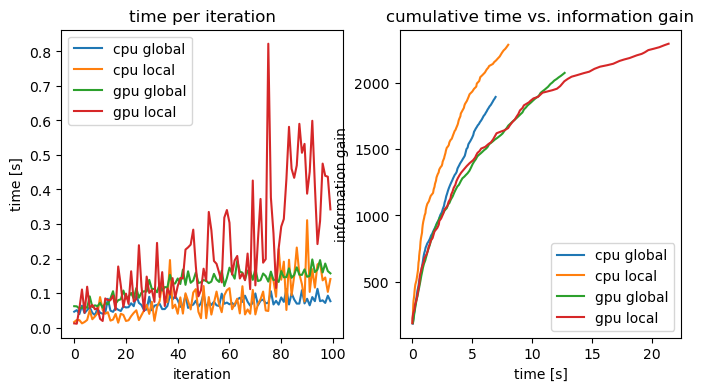

In [80]:
fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(times_cpu_g,label='cpu global')
ax[0].plot(times_cpu_l,label='cpu local')
ax[0].plot(times_gpu_g,label='gpu global')
ax[0].plot(times_gpu_l,label='gpu local')
ax[0].legend()
ax[0].set_title('time per iteration')
ax[0].set_xlabel('iteration')
ax[0].set_ylabel('time [s]')
# reset colors
ax[1].set_prop_cycle(None)
ax[1].plot(np.cumsum(times_cpu_g),info_cpu_g,label='cpu global')
ax[1].plot(np.cumsum(times_cpu_l),info_cpu_l,label='cpu local')
ax[1].plot(np.cumsum(times_gpu_g),info_gpu_g,label='gpu global')
ax[1].plot(np.cumsum(times_gpu_l),info_gpu_l,label='gpu local')
ax[1].legend()
ax[1].set_xlabel('time [s]')
ax[1].set_ylabel('information gain')
ax[1].set_title('cumulative time vs. information gain')


Text(0.5, 1.0, 'gpu local')

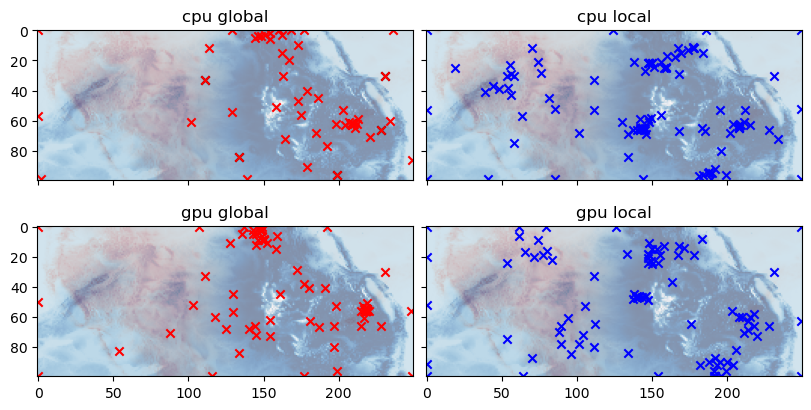

2023-06-14 13:42:03,601 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:63233', name: 3, status: running, memory: 0, processing: 0>
2023-06-14 13:42:03,610 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:63279', name: 0, status: running, memory: 0, processing: 0>
2023-06-14 13:42:03,611 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:64547', name: 0, status: running, memory: 0, processing: 0>
2023-06-14 13:42:03,613 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:63847', name: 15, status: running, memory: 0, processing: 0>
2023-06-14 13:42:03,616 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:64549', name: 20, status: run

In [ ]:
fig,axes = plt.subplots(2,2,figsize=(8,4),sharex=True,sharey=True,layout='constrained')
for ax in axes.flatten():
    ax.imshow(a[:,2].reshape(map_shape),alpha=0.5,cmap='Reds')
    ax.imshow(a[:,3].reshape(map_shape),alpha=0.5,cmap='Blues')
axes[0,0].scatter(init_points[:,1],init_points[:,0],c='k',marker='x',label='initial points')
axes[0,0].scatter(points_cpu_g[:,1],points_cpu_g[:,0],c='r',marker='x',label='cpu global')
axes[0,0].set_title('cpu global')

axes[0,1].scatter(points_cpu_l[:,1],points_cpu_l[:,0],c='b',marker='x',label='cpu local')
axes[0,1].set_title('cpu local')

axes[1,0].scatter(points_gpu_g[:,1],points_gpu_g[:,0],c='r',marker='x',label='gpu global')
axes[1,0].set_title('gpu global')

axes[1,1].scatter(points_gpu_l[:,1],points_gpu_l[:,0],c='b',marker='x',label='gpu local')
axes[1,1].set_title('gpu local')

    
# ax[0,0].imshow(values_cpu_g[:,0].reshape(100*3,250*3))

# Implement dask client

In [17]:
# import dask
# import dask.array as da
# import dask.dataframe as dd
# dask client/server
from dask.distributed import Client, LocalCluster


In [18]:
dask_server = LocalCluster(n_workers=4,threads_per_worker=1)

c:\Users\stein\anaconda3\envs\gpenv\lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 63250 instead
  warnings.warn(


In [19]:
dask_server

LocalCluster(ecbdf7e6, 'tcp://127.0.0.1:63251', workers=4, threads=4, memory=63.75 GiB)

In [20]:
info_cpu_g_dask, times_cpu_g_dask, points_cpu_g_dask, values_cpu_g_dask = run_gp(init_points,init_values,'cpu','global',dask_client=dask_server)


  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\stein\anaconda3\envs\gpenv\lib\site-packages\scipy\optimize\_differentialevolution.py:377: UserWarning: differential_evolution: the 'vectorized' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


In [21]:
info_cpu_g_dask_8, times_cpu_g_dask_8, points_cpu_g_dask_8, values_cpu_g_dask_8 = run_gp(init_points,init_values,'cpu','global',dask_client=dask_server)


  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\stein\anaconda3\envs\gpenv\lib\site-packages\scipy\optimize\_differentialevolution.py:377: UserWarning: differential_evolution: the 'vectorized' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


In [22]:
info_cpu_g_dask_16, times_cpu_g_dask_16, points_cpu_g_dask_16, values_cpu_g_dask_16 = run_gp(init_points,init_values,'cpu','global',dask_client=dask_server)


  0%|          | 0/100 [00:00<?, ?it/s]

In [23]:
info_cpu_g_dask_1, times_cpu_g_dask_1, points_cpu_g_dask_1, values_cpu_g_dask_1 = run_gp(init_points,init_values,'cpu','global',dask_client=dask_server)

  0%|          | 0/100 [00:00<?, ?it/s]

In [45]:
info_cpu_g_dask_1, times_cpu_g_dask_1, points_cpu_g_dask_1, values_cpu_g_dask_1 = run_gp(init_points,init_values,'gpu','global',dask_client=dask_server)


  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\stein\anaconda3\envs\gpenv\lib\site-packages\scipy\optimize\_differentialevolution.py:377: UserWarning: differential_evolution: the 'vectorized' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


In [25]:
times = [
    times_cpu_g,
    times_cpu_g_dask,
    times_cpu_g_dask_8,
    times_cpu_g_dask_16,
    times_cpu_g_dask_1,
    times_cpu_l,
    times_gpu_g,
    times_gpu_l,
]
infos = [
    info_cpu_g,
    info_cpu_g_dask,
    info_cpu_g_dask_8,
    info_cpu_g_dask_16,
    info_cpu_g_dask_1,
    info_cpu_l,
    info_gpu_g,
    info_gpu_l,
]
labels = [
    'cpu global',
    'cpu global dask',
    'cpu global dask 8',
    'cpu global dask 16',
    'cpu global dask 1',
    'cpu local',
    'gpu global',
    'gpu local',
]

In [30]:
%matplotlib widget

ModuleNotFoundError: No module named 'ipympl'

In [37]:
from scipy.signal import savgol_filter, butter, filtfilt

Text(0.5, 1.0, 'cumulative time vs. information gain')

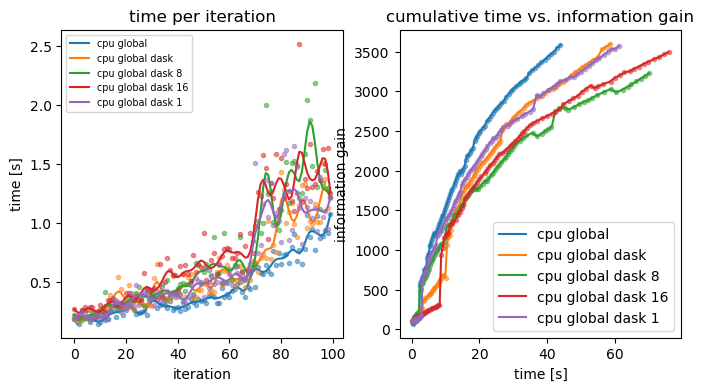

In [42]:
fig,ax = plt.subplots(1,2,figsize=(8,4))
for i,time_,info,label in zip(range(len(times)),times,infos,labels):
    if i == 5:
        break
    l = ax[0].plot(time_,'.',alpha=0.5)
    # plot filtered with same color
    time_filt = savgol_filter(time_,51,3)
    time_filt = filtfilt(*butter(3,.3),time_)
    ax[0].plot(time_filt,label=label,c=l[0].get_color(),alpha=1)
    ax[1].plot(np.cumsum(time_),info,'.',alpha=.5)
    ax[1].plot(np.cumsum(time_filt),info,label=label,c=l[0].get_color(),alpha=1)

ax[0].legend(fontsize='x-small')
ax[0].set_title('time per iteration')
ax[0].set_xlabel('iteration')
ax[0].set_ylabel('time [s]')
ax[1].legend()
ax[1].set_xlabel('time [s]')
ax[1].set_ylabel('information gain')
ax[1].set_title('cumulative time vs. information gain')
